In [1]:
import os
import mahotas as mt
import cv2 as cv
import glob
import numpy as np
import csv
import re
import count_train
import count_test
import matplotlib.pyplot as plt
from scipy import stats

# Dataset

### A set of 202 diseased(1- algal leaf spot, 2- blister blight, 3- grey spot) and healthy(0) tea leaves are collected as dataset from High Field Tea Estate, Coonoor, Tamil Nadu, India.

## The Next Step is Image Segmentation.

#### A python script file is used for background removal and extraction of area of interest.

#### Image Augmentation is done to increase the dataset.

## The Next Step is the Feature Extraction. 

#### 13 Texture Features( Haralick features are used).
#### Color Features
#### Shape Features

In [2]:
def extract_feature(image):
	
	##Color Feature
	(mean,std) = cv.meanStdDev(image)
	
	#print(len(mean), type(mean))
	
	#print(len(std), type(std))
	
	color_feature = np.array(mean)
	
	color_feature = np.concatenate([color_feature,std]).flatten()
	
	#print(len(color_feature))
	
	##Texture Feature
	gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
	
	textures = mt.features.haralick(gray)
	
	ht_mean = textures.mean(axis = 0)
	
	#print(len(ht_mean), type(ht_mean))
	
	
	## Shape Features
	ret,thresh = cv.threshold(gray,127,255,0)
	
	x,contours, hierarchy =   cv.findContours(thresh.copy(),1,2)
	
	cnt = contours[0]
	
	area = cv.contourArea(cnt)
	#print(type(area))
	
	perimeter = cv.arcLength(cnt,True)
	#print(type(perimeter))
	
	shape = np.array([])
	shape = np.append(shape,area)
	shape = np.append(shape,perimeter)
	#print(len(shape))
	
	
	#print(len(ht_mean) + len(std) + len(mean) + len(shape))
	
	ht_mean = np.concatenate([ht_mean,color_feature]).flatten()
	
	ht_mean = np.concatenate([ht_mean,shape]).flatten()
	
	#print(len(ht_mean),ht_mean.shape)
	
	return(ht_mean)

# Creating Comma-Seperating file

#### A CSV file, having 21 features (13 texture features, 6 color features and 2 shape featrures) and appropriate label(0- Healthy, 1- Algal Leaf Spot, 2- blister blight, 3- Grey Spot), is created.

In [3]:
def create_csv(pa):	
	if(pa == 'train'):
		files = count_train.images()
		path = '/home/ln-2/Desktop/Project/disease-final/train'
	else:
		files = count_test.images()
		path = '/home/ln-2/Desktop/Project/disease-final/test'

	mydata = [['energy','contrast','correlation','variance','inverse difference moment','sum average','sum variance',
               'sum entropy','entropy','difference variance','difference entropy','info_corr',
			   'maximal_corr_coeff','mean_B','mean_G','mean_R','std_B','std_G','std_R','area','perimeter','label']]

	
	print(path)
	for file in files:	
		#print(path+ file)
		image = cv.imread(path + '/' + file)
		#print(file)
		#gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
		#means = cv.mean(image)
		#print(len(means))
		#print(image.shape)
		dim = (512,512)
		r_img = cv.resize(image,dim)
		#print(r_img.shape)
		feature = extract_feature(r_img)
		label = 0
		
		## Healthy leaf is labeled as 0.
		if(re.search('test[1-9]+',file)):
			label = 0
		else:
			## Algal leaf spot is labeled as 1.
			if(re.search('algal[1-9]+',file)):
				label = 1
			## Blister Blight is labeled as 2.	
			elif(re.search('blister[1-9]+',file)):
				label = 2
			## Grey Spot is labled as 3.	
			elif(re.search('grey[1-9]+',file)):
				label = 3
		
		feature = np.append(feature,label)
		#print(len(feature))
		#print()
		feature = feature.tolist()
		mydata.append(feature)

	myfile = open(pa+'.csv','w')
	with myfile:
        	writer = csv.writer(myfile)
        	writer.writerows(mydata)


In [4]:
create_csv('train')

210
/home/ln-2/Desktop/Project/disease-final/train


In [5]:
create_csv('test')

336
/home/ln-2/Desktop/Project/disease-final/test


## Importing Panda Library and matplotlib library

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
myfile = pd.read_csv('train.csv',sep=',')

In [8]:
myfile.head()

,energy,contrast,correlation,variance,inverse difference moment,sum average,sum variance,sum entropy,entropy,difference variance,...,maximal_corr_coeff,mean_B,mean_G,mean_R,std_B,std_G,std_R,area,perimeter,label
0,0.347799,32.588360,0.996001,4073.718677,0.692237,90.147074,16262.286347,4.060041,5.492437,0.001941,...,0.984891,37.913227,52.039234,33.716755,56.086775,74.006186,48.231704,0.0,4.000000,3.0
1,0.685243,50.605523,0.993072,3651.582357,0.883845,46.906037,14555.723905,2.062261,2.590868,0.002851,...,0.943195,7.773327,27.139809,21.971058,34.459016,69.059332,57.767431,0.0,0.000000,0.0
2,0.016088,34.550121,0.981376,928.198635,0.538005,95.696787,3678.244421,6.959613,9.013186,0.001003,...,0.998898,55.284832,52.648376,35.205551,35.604039,32.248428,26.516221,10.5,25.899495,1.0
3,0.016819,144.748239,0.978273,3333.142373,0.399259,213.645020,13187.821252,7.478902,10.371518,0.000554,...,0.997809,99.553635,148.902649,25.969700,61.136347,75.038394,44.966868,2.0,5.656854,0.0
4,0.053403,20.355082,0.988156,859.393922,0.573747,73.045556,3417.220605,6.276959,8.120832,0.001346,...,0.998040,22.985626,38.088875,38.212006,19.937029,29.868182,32.685514,4.5,8.242641,1.0


In [9]:
myfile.tail()

,energy,contrast,correlation,variance,inverse difference moment,sum average,sum variance,sum entropy,entropy,difference variance,...,maximal_corr_coeff,mean_B,mean_G,mean_R,std_B,std_G,std_R,area,perimeter,label
205,0.172880,26.149811,0.998154,7084.417731,0.639548,159.509086,28311.521115,5.616815,7.220765,0.001337,...,0.998024,87.935623,89.182465,57.427036,91.824132,93.984305,62.831595,0.0,2.000000,3.0
206,0.016765,35.291023,0.983031,1040.588015,0.551603,103.255291,4127.061038,7.013121,9.016554,0.001016,...,0.999119,35.239807,52.734543,55.198208,26.607106,32.337907,35.690235,13.0,26.485281,1.0
207,0.216509,144.569213,0.983831,4470.411948,0.587461,123.962161,17737.078580,5.100044,7.098211,0.001109,...,0.989748,35.401810,86.216957,24.016743,48.187980,89.520593,44.368737,2.0,5.656854,0.0
208,0.745571,58.144256,0.988725,2577.891604,0.910633,33.058658,10253.422161,1.647037,2.034856,0.003187,...,0.914385,1.644012,19.672615,15.876183,9.344624,60.071701,50.260687,9767.0,821.234623,0.0
209,0.052369,20.066240,0.986136,723.817872,0.565398,67.402160,2875.205249,6.205351,8.079562,0.001349,...,0.997578,38.293427,38.115753,23.007015,32.696359,29.857899,19.954715,3.5,9.414214,1.0


In [10]:
myfile = myfile.dropna()

In [11]:
myfile[47:]['difference entropy']

47     2.526005
48     0.781743
49     0.955553
50     2.477696
51     1.102803
52     2.482238
53     1.395889
54     2.590067
55     0.965193
56     2.609335
57     0.686429
58     1.737232
59     3.154758
60     2.314290
61     1.602425
62     1.234028
63     2.535870
64     2.355456
65     1.122135
66     1.331944
67     2.478876
68     1.050875
69     2.715698
70     2.366642
71     0.971500
72     2.532251
73     1.298320
74     0.971769
75     3.170543
76     1.597560
         ...   
180    1.329303
181    2.456993
182    0.669801
183    2.537265
184    1.637244
185    0.941759
186    1.120696
187    1.075900
188    2.538832
189    0.816219
190    1.035360
191    0.740381
192    2.659860
193    2.479542
194    0.821567
195    2.519733
196    2.347758
197    2.597783
198    1.180481
199    0.943932
200    3.545244
201    2.583440
202    0.833003
203    1.127644
204    0.956076
205    2.462969
206    2.638731
207    3.030812
208    0.937370
209    2.587310
Name: difference entropy

### Seperating the labels

In [12]:
train_data = myfile.iloc[:,:-1]

In [13]:
train_label = myfile.iloc[:,-1]

In [14]:
train_label = train_label.astype(int)

## Statistical Analysis

Text(0.5,1,'Correlation between features')

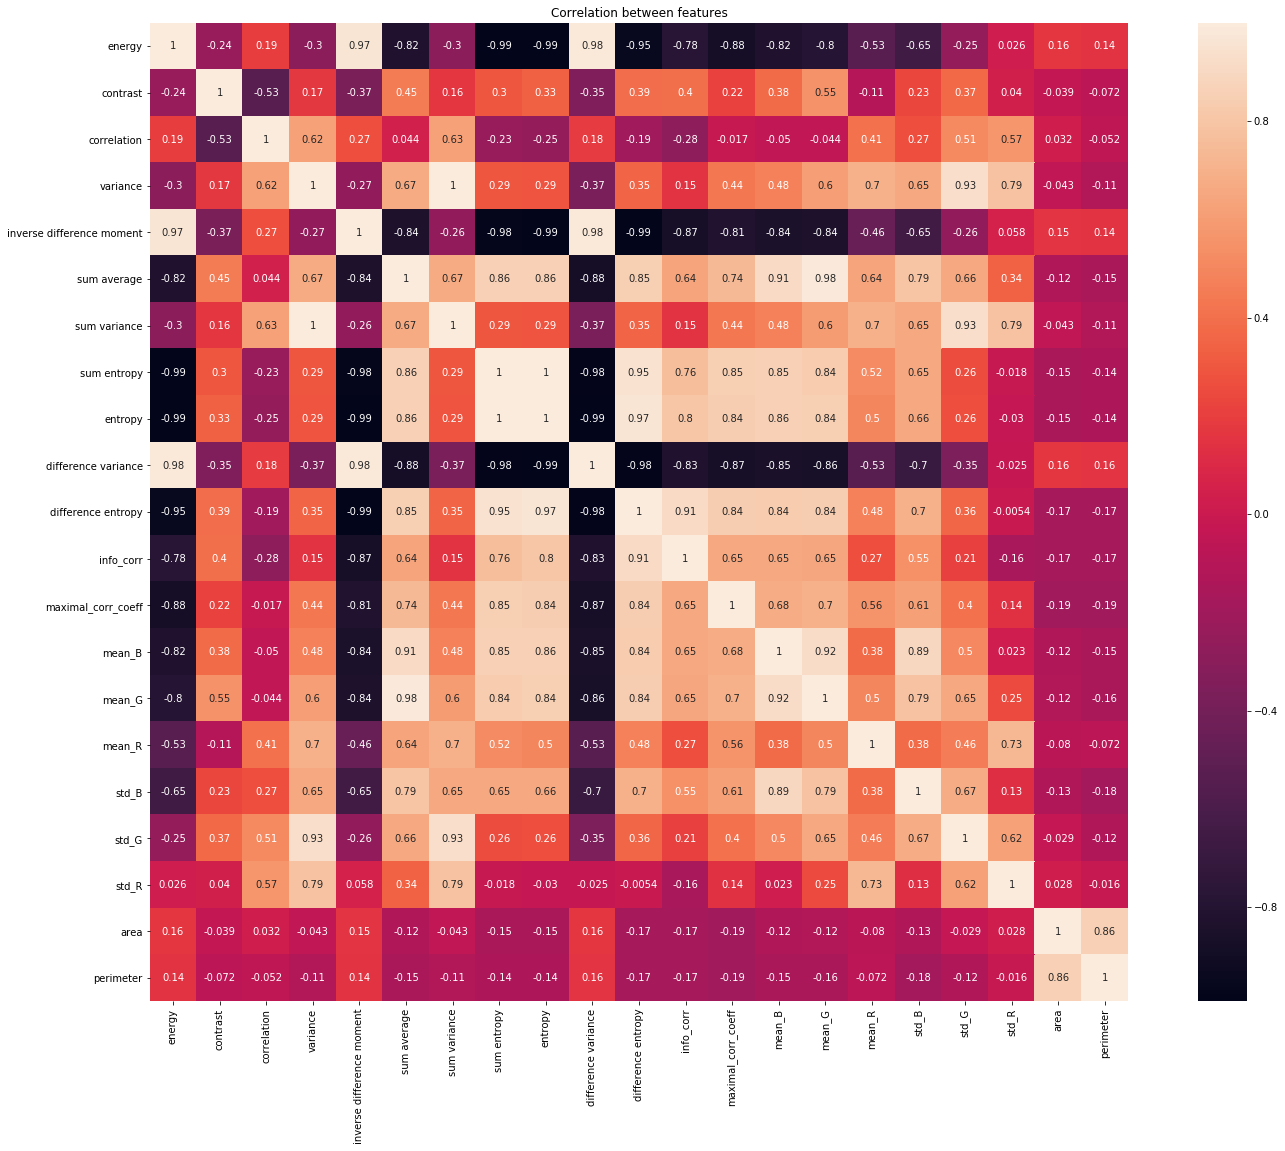

In [15]:
plt.figure(figsize=(25,18))
corr = train_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, square=True,annot=True,linecolor="black") #cmap='YlGnBu',
plt.title("Correlation between features")

In [16]:
from sklearn import preprocessing

In [17]:
standard = preprocessing.StandardScaler()

In [18]:
min_element = []
max_element = []

In [19]:
train_label.describe()

count    210.000000
mean       1.023810
std        1.215689
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        3.000000
Name: label, dtype: float64

In [20]:
train_data['energy'].describe()

count    210.000000
mean       0.335399
std        0.273101
min        0.011070
25%        0.096996
50%        0.206185
75%        0.623867
max        0.824460
Name: energy, dtype: float64

In [21]:
min_element.append(train_data['energy'].min())
max_element.append(train_data['energy'].max())

In [22]:
train_data['energy'] = (train_data['energy'] - train_data['energy'].min())/(train_data['energy'].max() - train_data['energy'].min()) 

/home/ln-2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
train_data['energy'].describe()

count    210.000000
mean       0.398737
std        0.335757
min        0.000000
25%        0.105639
50%        0.239879
75%        0.753386
max        1.000000
Name: energy, dtype: float64

In [24]:
train_data['contrast'].describe()

count    210.000000
mean      52.146338
std       34.295889
min       15.572684
25%       29.010006
50%       40.922366
75%       65.720756
max      199.727988
Name: contrast, dtype: float64

In [25]:
min_element.append(train_data['contrast'].min())
max_element.append(train_data['contrast'].max())

In [26]:
train_data['contrast'] = (train_data['contrast'] - train_data['contrast'].min())/(train_data['contrast'].max() - train_data['contrast'].min())

/home/ln-2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
train_data['contrast'].describe()

count    210.000000
mean       0.198602
std        0.186234
min        0.000000
25%        0.072967
50%        0.137654
75%        0.272314
max        1.000000
Name: contrast, dtype: float64

In [28]:
train_data['correlation'].describe()

count    210.000000
mean       0.992010
std        0.005098
min        0.976039
25%        0.988890
50%        0.993195
75%        0.995999
max        0.998267
Name: correlation, dtype: float64

In [29]:
train_data = train_data.drop('correlation', 1)

In [30]:
train_data['variance'].describe()

count     210.000000
mean     4037.867010
std      1959.732794
min       723.765969
25%      2683.607394
50%      4074.211772
75%      5329.164904
max      8034.254523
Name: variance, dtype: float64

In [31]:
min_element.append(train_data['variance'].min())
max_element.append(train_data['variance'].max())

In [32]:
train_data['variance'] = (train_data['variance'] - train_data['variance'].min())/(train_data['variance'].max() - train_data['variance'].min())

In [33]:
train_data['variance'].describe()

count    210.000000
mean       0.453335
std        0.268071
min        0.000000
25%        0.268086
50%        0.458307
75%        0.629971
max        1.000000
Name: variance, dtype: float64

In [34]:
train_data['inverse difference moment'].describe()

count    210.000000
mean       0.691499
std        0.161440
min        0.370535
25%        0.565756
50%        0.636282
75%        0.871852
max        0.943054
Name: inverse difference moment, dtype: float64

In [35]:
min_element.append(train_data['inverse difference moment'].min())
max_element.append(train_data['inverse difference moment'].max())

In [36]:
train_data['inverse difference moment'] = (train_data['inverse difference moment'] - train_data['inverse difference moment'].min())/(train_data['inverse difference moment'].max() - train_data['inverse difference moment'].min())

In [37]:
train_data['inverse difference moment'].describe()

count    210.000000
mean       0.560617
std        0.281982
min        0.000000
25%        0.340985
50%        0.464172
75%        0.875633
max        1.000000
Name: inverse difference moment, dtype: float64

In [38]:
train_data['sum average'].describe()

count    210.000000
mean     106.644045
std       59.869110
min       19.381805
25%       54.946969
50%       95.696655
75%      147.898893
max      258.353514
Name: sum average, dtype: float64

In [39]:
min_element.append(train_data['sum average'].min())
max_element.append(train_data['sum average'].max())

In [40]:
train_data['sum average'] = (train_data['sum average'] - train_data['sum average'].min())/(train_data['sum average'].max() - train_data['sum average'].min())

In [41]:
train_data['sum average'].describe()

count    210.000000
mean       0.365157
std        0.250528
min        0.000000
25%        0.148826
50%        0.319347
75%        0.537792
max        1.000000
Name: sum average, dtype: float64

In [42]:
train_data['sum variance'].describe()

count      210.000000
mean     16099.321702
std       7833.209346
min       2875.027328
25%      10701.562637
50%      16264.523102
75%      21287.260971
max      32107.124025
Name: sum variance, dtype: float64

In [43]:
min_element.append(train_data['sum variance'].min())
max_element.append(train_data['sum variance'].max())

In [44]:
train_data['sum variance'] = (train_data['sum variance'] - train_data['sum variance'].min())/(train_data['sum variance'].max() - train_data['sum variance'].min())

In [45]:
train_data['sum variance'].describe()

count    210.000000
mean       0.452390
std        0.267966
min        0.000000
25%        0.267738
50%        0.458041
75%        0.629864
max        1.000000
Name: sum variance, dtype: float64

In [46]:
train_data['sum entropy'].describe()

count    210.000000
mean       4.521903
std        2.028916
min        1.116526
25%        2.356806
50%        5.149687
75%        6.298093
max        7.665840
Name: sum entropy, dtype: float64

In [47]:
min_element.append(train_data['sum entropy'].min())
max_element.append(train_data['sum entropy'].max())

In [48]:
train_data['sum entropy'] = (train_data['sum entropy'] - train_data['sum entropy'].min())/(train_data['sum entropy'].max() - train_data['sum entropy'].min())

In [49]:
train_data['sum entropy'].describe()

count    210.000000
mean       0.519959
std        0.309791
min        0.000000
25%        0.189376
50%        0.615814
75%        0.791162
max        1.000000
Name: sum entropy, dtype: float64

In [50]:
train_data['entropy'].describe()

count    210.000000
mean       5.921335
std        2.762364
min        1.384899
25%        2.932762
50%        6.815122
75%        8.253478
max       10.380966
Name: entropy, dtype: float64

In [51]:
min_element.append(train_data['entropy'].min())
max_element.append(train_data['entropy'].max())

In [52]:
train_data['entropy'] = (train_data['entropy'] - train_data['entropy'].min())/(train_data['entropy'].max() - train_data['entropy'].min())

In [53]:
train_data['entropy'].describe()

count    210.000000
mean       0.504269
std        0.307063
min        0.000000
25%        0.172060
50%        0.603622
75%        0.763509
max        1.000000
Name: entropy, dtype: float64

In [54]:
train_data['difference variance'].describe()

count    210.000000
mean       0.001810
std        0.000878
min        0.000474
25%        0.001112
50%        0.001399
75%        0.002710
max        0.003534
Name: difference variance, dtype: float64

In [55]:
min_element.append(train_data['difference variance'].min())
max_element.append(train_data['difference variance'].max())

In [56]:
train_data['difference variance'] = (train_data['difference variance'] - train_data['difference variance'].min())/(train_data['difference variance'].max() - train_data['difference variance'].min())

In [57]:
train_data['difference variance'].describe()

count    210.000000
mean       0.436679
std        0.286884
min        0.000000
25%        0.208655
50%        0.302305
75%        0.730649
max        1.000000
Name: difference variance, dtype: float64

In [58]:
train_data['difference entropy'].describe()

count    210.000000
mean       2.140653
std        0.846114
min        0.639086
25%        1.214267
50%        2.479740
75%        2.636029
max        3.858008
Name: difference entropy, dtype: float64

In [59]:
min_element.append(train_data['difference entropy'].min())
max_element.append(train_data['difference entropy'].max())

In [60]:
train_data['difference entropy'] = (train_data['difference entropy'] - train_data['difference entropy'].min())/(train_data['difference entropy'].max() - train_data['difference entropy'].min())

In [61]:
train_data['difference entropy'].describe()

count    210.000000
mean       0.466481
std        0.262856
min        0.000000
25%        0.178688
50%        0.571823
75%        0.620376
max        1.000000
Name: difference entropy, dtype: float64

In [62]:
train_data['info_corr'].describe()

count    210.000000
mean      -0.544615
std        0.063999
min       -0.658901
25%       -0.604890
50%       -0.534008
75%       -0.502728
max       -0.376629
Name: info_corr, dtype: float64

In [63]:
train_data = train_data.drop('info_corr', 1)

In [64]:
train_data['maximal_corr_coeff'].describe()

count    210.000000
mean       0.974758
std        0.034879
min        0.834630
25%        0.963706
50%        0.994783
75%        0.997963
max        0.999571
Name: maximal_corr_coeff, dtype: float64

In [65]:
train_data = train_data.drop('maximal_corr_coeff', 1)

In [66]:
train_data['mean_B'].describe()

count    210.000000
mean      42.789125
std       34.563717
min        0.906940
25%        8.228772
50%       37.910202
75%       70.521297
max      130.777790
Name: mean_B, dtype: float64

In [67]:
min_element.append(train_data['mean_B'].min())
max_element.append(train_data['mean_B'].max())

In [68]:
train_data['mean_B'] = (train_data['mean_B'] - train_data['mean_B'].min())/(train_data['mean_B'].max() - train_data['mean_B'].min())

In [69]:
train_data['mean_B'].describe()

count    210.000000
mean       0.322491
std        0.266139
min        0.000000
25%        0.056378
50%        0.284924
75%        0.536028
max        1.000000
Name: mean_B, dtype: float64

In [70]:
train_data['mean_G'].describe()

count    210.000000
mean      64.562584
std       38.675813
min       11.735050
25%       31.342188
50%       52.692743
75%       92.960029
max      166.321705
Name: mean_G, dtype: float64

In [71]:
min_element.append(train_data['mean_G'].min())
max_element.append(train_data['mean_G'].max())

In [72]:
train_data['mean_G'] = (train_data['mean_G'] - train_data['mean_G'].min())/(train_data['mean_G'].max() - train_data['mean_G'].min())

In [73]:
train_data['mean_G'].describe()

count    210.000000
mean       0.341734
std        0.250189
min        0.000000
25%        0.126836
50%        0.264950
75%        0.525433
max        1.000000
Name: mean_G, dtype: float64

In [74]:
train_data['mean_R'].describe()

count    210.000000
mean      34.784810
std       20.642948
min        4.393021
25%       21.345133
50%       29.980841
75%       40.193374
max       87.934929
Name: mean_R, dtype: float64

In [75]:
min_element.append(train_data['mean_R'].min())
max_element.append(train_data['mean_R'].max())

In [76]:
train_data['mean_R'] = (train_data['mean_R'] - train_data['mean_R'].min())/(train_data['mean_R'].max() - train_data['mean_R'].min())

In [77]:
train_data['mean_R'].describe()

count    210.000000
mean       0.363791
std        0.247097
min        0.000000
25%        0.202917
50%        0.306287
75%        0.428532
max        1.000000
Name: mean_R, dtype: float64

In [78]:
train_data['std_B'].describe()

count    210.000000
mean      47.048231
std       23.953210
min        5.822116
25%       25.021123
50%       44.466202
75%       70.816801
max       99.473150
Name: std_B, dtype: float64

In [79]:
min_element.append(train_data['std_B'].min())
max_element.append(train_data['std_B'].max())

In [80]:
train_data['std_B'] = (train_data['std_B'] - train_data['std_B'].min())/(train_data['std_B'].max() - train_data['std_B'].min())

In [81]:
train_data['std_B'].describe()

count    210.000000
mean       0.440210
std        0.255771
min        0.000000
25%        0.205006
50%        0.412639
75%        0.694009
max        1.000000
Name: std_B, dtype: float64

In [82]:
train_data['std_G'].describe()

count    210.000000
mean      72.215921
std       20.215001
min       29.857774
25%       60.811449
50%       75.700867
75%       87.277320
max      117.608446
Name: std_G, dtype: float64

In [83]:
min_element.append(train_data['std_G'].min())
max_element.append(train_data['std_G'].max())

In [84]:
train_data['std_G'] = (train_data['std_G'] - train_data['std_G'].min())/(train_data['std_G'].max() - train_data['std_G'].min())

In [85]:
train_data['std_G'].describe()

count    210.000000
mean       0.482710
std        0.230369
min        0.000000
25%        0.352746
50%        0.522424
75%        0.654349
max        1.000000
Name: std_G, dtype: float64

In [86]:
train_data['std_R'].describe()

count    210.000000
mean      50.448343
std       17.792242
min       13.865330
25%       37.578972
50%       48.239180
75%       62.826840
max       91.890115
Name: std_R, dtype: float64

In [87]:
min_element.append(train_data['std_R'].min())
max_element.append(train_data['std_R'].max())

In [88]:
train_data['std_R'] = (train_data['std_R'] - train_data['std_R'].min())/(train_data['std_R'].max() - train_data['std_R'].min())

In [89]:
train_data['std_R'].describe()

count    210.000000
mean       0.468864
std        0.228033
min        0.000000
25%        0.303924
50%        0.440550
75%        0.627512
max        1.000000
Name: std_R, dtype: float64

In [90]:
train_data['area'].describe()

count      210.000000
mean       308.911905
std       2705.727871
min          0.000000
25%          0.625000
50%          2.000000
75%          8.500000
max      33678.500000
Name: area, dtype: float64

In [91]:
train_data = train_data.drop('area', 1)

In [92]:
train_data['perimeter'].describe()

count    210.000000
mean      26.235918
std       98.186102
min        0.000000
25%        5.474874
50%        6.535534
75%       12.424621
max      865.511753
Name: perimeter, dtype: float64

In [93]:
train_data = train_data.drop('perimeter', 1)

In [94]:
train_data = train_data.drop('entropy', 1)

In [95]:
train_data.head()

,energy,contrast,variance,inverse difference moment,sum average,sum variance,sum entropy,difference variance,difference entropy,mean_B,mean_G,mean_R,std_B,std_G,std_R
0,0.413983,0.092399,0.458239,0.561906,0.296124,0.457964,0.449439,0.479387,0.537618,0.284947,0.260722,0.351006,0.536723,0.503112,0.440455
1,0.828843,0.190235,0.400495,0.896582,0.115178,0.399585,0.144402,0.776815,0.159322,0.052871,0.099651,0.210410,0.305783,0.446738,0.562669
2,0.006170,0.103051,0.027964,0.292514,0.319347,0.027477,0.892168,0.172765,0.630146,0.418707,0.264663,0.368827,0.318010,0.027244,0.162139
3,0.007068,0.701449,0.356936,0.050170,0.812913,0.352790,0.971457,0.026144,0.896972,0.759575,0.887319,0.258274,0.590642,0.514875,0.398611
4,0.052045,0.025969,0.018553,0.354943,0.224561,0.018548,0.787935,0.285097,0.599925,0.170005,0.170479,0.404815,0.150718,0.000119,0.241208


Text(0.5,1,'Correlation between features')

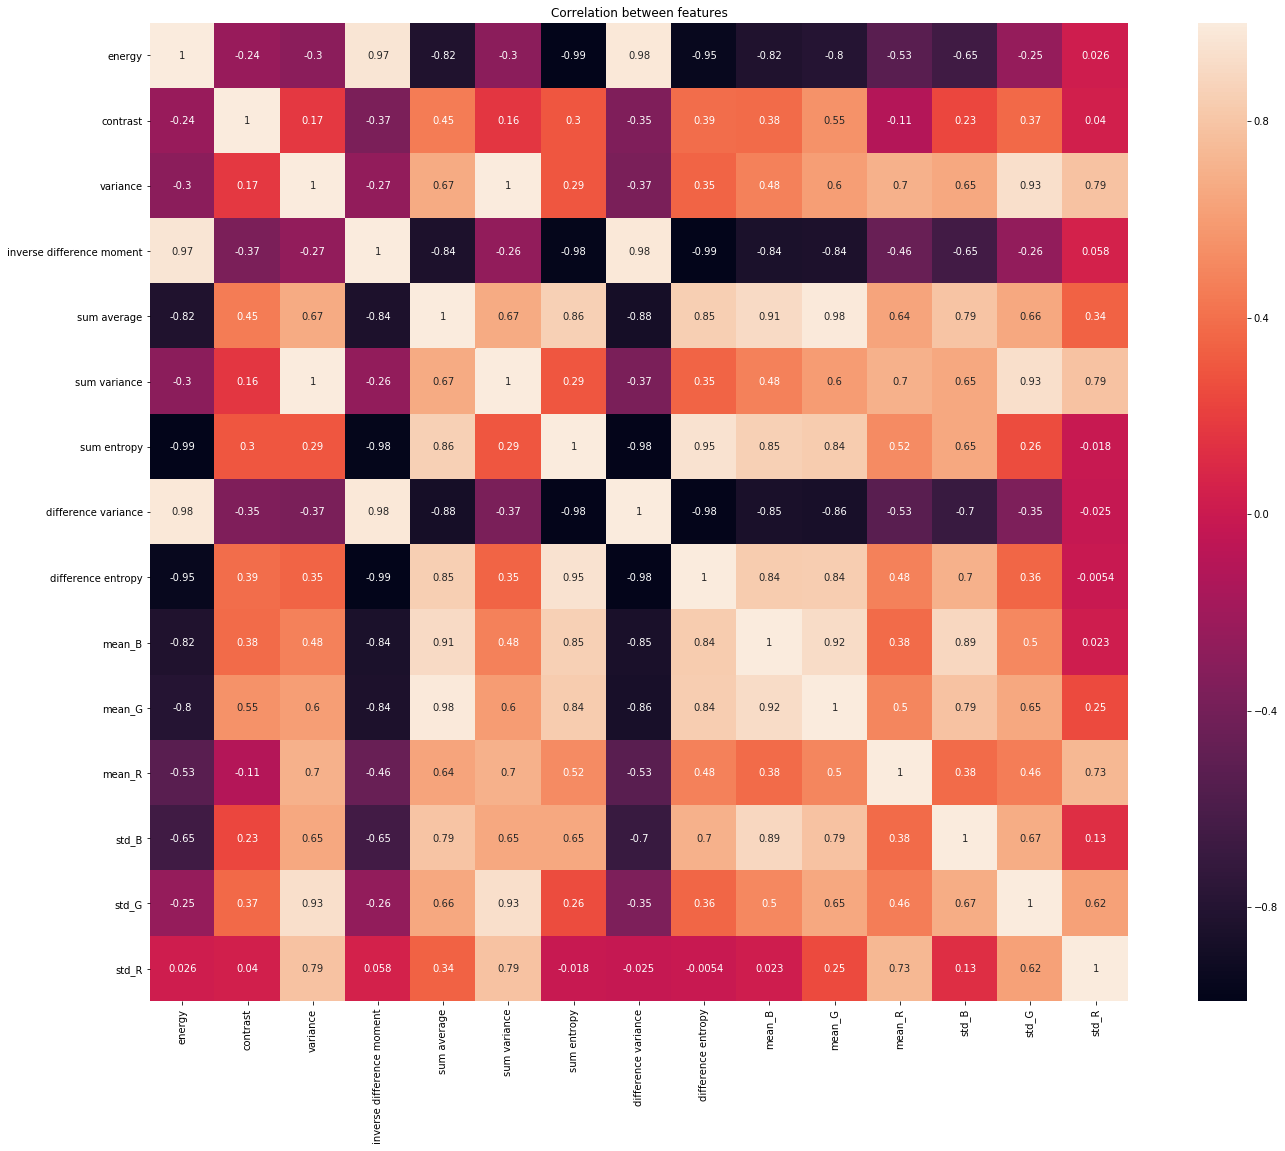

In [96]:
plt.figure(figsize=(25, 18))
corr = train_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, square=True,annot=True,linecolor="black") #cmap='YlGnBu',
plt.title("Correlation between features")

In [97]:
train_data = train_data.drop('sum variance', 1)

### Statistical Analysis of Test dataset

In [98]:
test = pd.read_csv('test.csv')

In [99]:
test.head()

,energy,contrast,correlation,variance,inverse difference moment,sum average,sum variance,sum entropy,entropy,difference variance,...,maximal_corr_coeff,mean_B,mean_G,mean_R,std_B,std_G,std_R,area,perimeter,label
0,0.027614,75.876049,0.989063,3470.442224,0.374566,188.172519,13805.892846,7.185458,10.225069,0.000508,...,0.995927,110.672779,120.317806,35.355999,70.883012,76.101307,31.148942,2.0,5.656854,1.0
1,0.608491,69.903593,0.985977,2491.946158,0.861429,45.117940,9897.881040,2.470234,3.084804,0.002641,...,0.966300,21.281883,31.361919,5.540855,48.681124,68.800080,20.708447,0.0,6.000000,0.0
2,0.774782,40.664489,0.990493,2138.230310,0.931399,29.151960,8512.256752,1.404731,1.691952,0.003352,...,0.894826,2.985298,17.295013,13.519966,15.772796,54.802283,43.304531,2.0,5.656854,0.0
3,0.512548,66.226205,0.990938,3653.219553,0.805368,63.610339,14546.652007,3.228891,4.136742,0.002263,...,0.981659,10.598244,37.527039,28.357140,32.558882,69.544082,56.139926,0.0,0.000000,0.0
4,0.681286,43.313882,0.987096,1677.881036,0.883863,31.407314,6668.210263,2.031875,2.552463,0.002906,...,0.943898,16.325077,21.885483,3.178383,43.928372,57.206220,13.287565,2.0,5.656854,0.0


#### Seperating the labels

In [100]:
test_data = test.iloc[:,:-1]
test_label = test.iloc[:,-1]
test_label = test_label.astype(int)

Text(0.5,1,'Correlation between features')

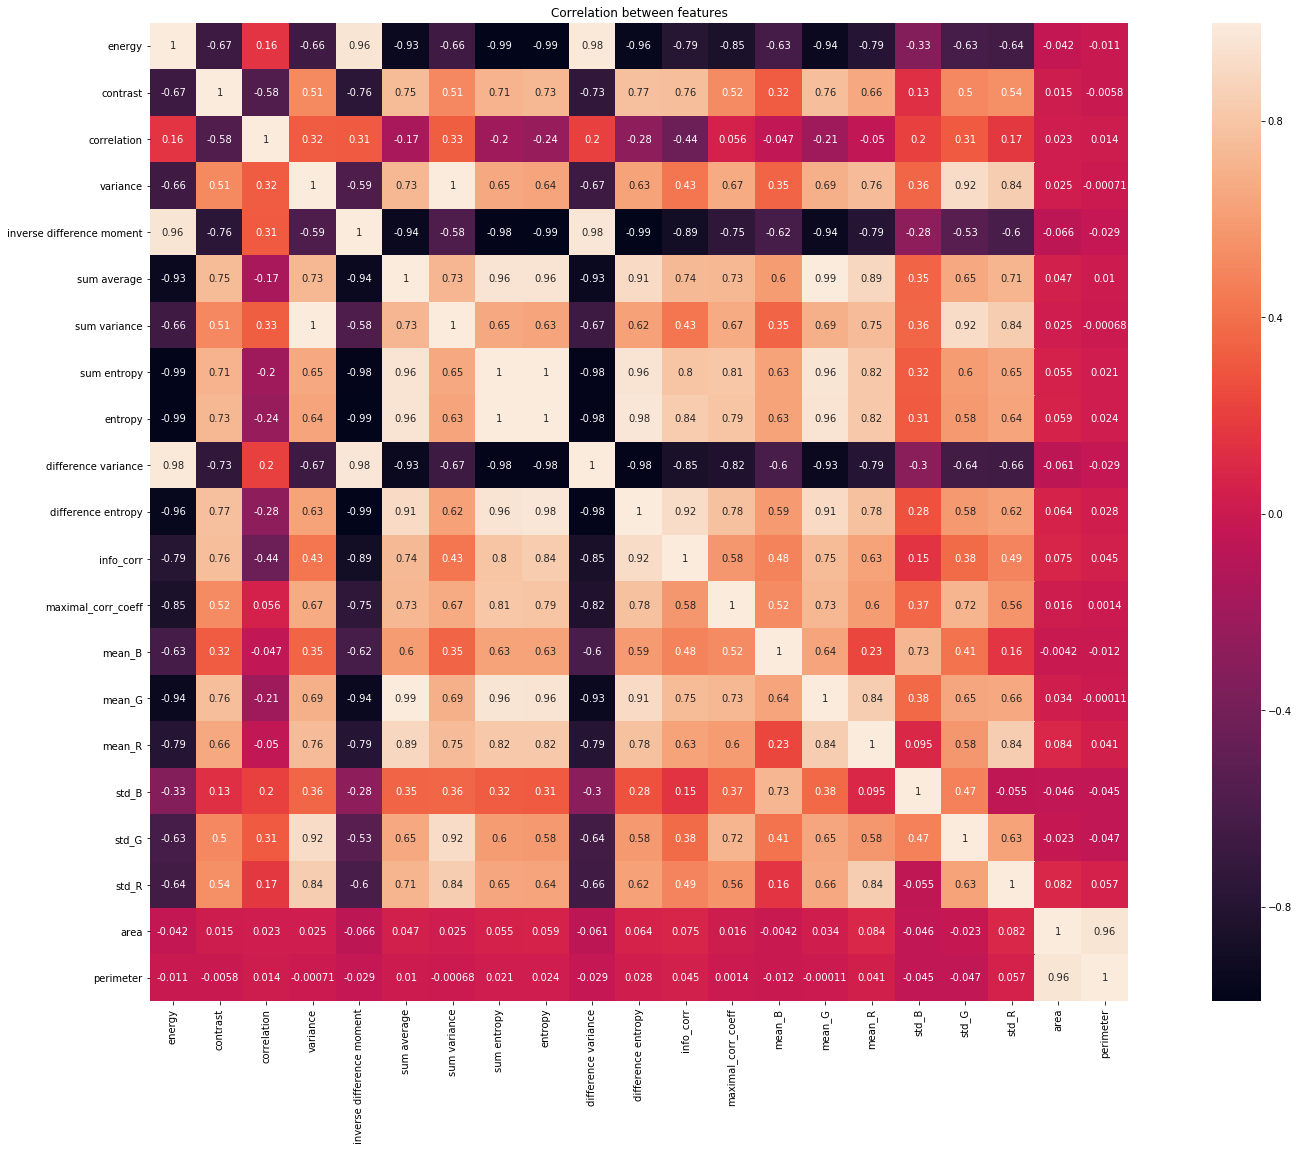

In [101]:
plt.figure(figsize=(30,18))
corr = test_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, square=True,annot=True,linecolor="black") #cmap='YlGnBu',
plt.title("Correlation between features")

In [102]:
test_label.describe()

count    336.000000
mean       0.217262
std        0.671687
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: label, dtype: float64

In [103]:
test_data['energy'].describe()

count    336.000000
mean       0.381219
std        0.283994
min        0.004658
25%        0.094548
50%        0.329738
75%        0.645981
max        0.845630
Name: energy, dtype: float64

In [104]:
test_data['energy'] = (test_data['energy'] - test_data['energy'].min())/(test_data['energy'].max() - test_data['energy'].min()) 

/home/ln-2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [105]:
test_data['energy'].describe()

count    336.000000
mean       0.447769
std        0.337697
min        0.000000
25%        0.106888
50%        0.386553
75%        0.762597
max        1.000000
Name: energy, dtype: float64

In [106]:
test_data['contrast'].describe()

count    336.000000
mean      69.561838
std       38.245206
min       17.425366
25%       40.412398
50%       64.899196
75%       89.125763
max      204.489528
Name: contrast, dtype: float64

In [107]:
test_data['contrast'] = (test_data['contrast'] - test_data['contrast'].min())/(test_data['contrast'].max() - test_data['contrast'].min())

/home/ln-2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [108]:
train_data['contrast'].describe()

count    210.000000
mean       0.198602
std        0.186234
min        0.000000
25%        0.072967
50%        0.137654
75%        0.272314
max        1.000000
Name: contrast, dtype: float64

In [109]:
test_data['correlation'].describe()

count    336.000000
mean       0.990533
std        0.004059
min        0.975925
25%        0.988728
50%        0.990947
75%        0.993186
max        0.998248
Name: correlation, dtype: float64

In [110]:
test_data = test_data.drop('correlation', 1)

In [111]:
test_data['variance'].describe()

count      336.000000
mean      3909.610298
std       1712.638597
min        723.917281
25%       2586.573185
50%       3621.877886
75%       5046.901349
max      10235.974329
Name: variance, dtype: float64

In [112]:
test_data['variance'] = (test_data['variance'] - test_data['variance'].min())/(test_data['variance'].max() - test_data['variance'].min())

In [113]:
test_data['variance'].describe()

count    336.000000
mean       0.334911
std        0.180049
min        0.000000
25%        0.195821
50%        0.304662
75%        0.454474
max        1.000000
Name: variance, dtype: float64

In [114]:
test_data['inverse difference moment'].describe()

count    336.000000
mean       0.708510
std        0.183220
min        0.301643
25%        0.555854
50%        0.707041
75%        0.875487
max        0.943683
Name: inverse difference moment, dtype: float64

In [115]:
test_data['inverse difference moment'] = (test_data['inverse difference moment'] - test_data['inverse difference moment'].min())/(test_data['inverse difference moment'].max() - test_data['inverse difference moment'].min())

In [116]:
test_data['inverse difference moment'].describe()

count    336.000000
mean       0.633710
std        0.285371
min        0.000000
25%        0.395944
50%        0.631422
75%        0.893783
max        1.000000
Name: inverse difference moment, dtype: float64

In [117]:
test_data['sum average'].describe()

count    336.000000
mean     111.103021
std       76.046614
min       16.737848
25%       43.332638
50%       93.651646
75%      176.030230
max      286.639565
Name: sum average, dtype: float64

In [118]:
test_data['sum average'] = (test_data['sum average'] - test_data['sum average'].min())/(test_data['sum average'].max() - test_data['sum average'].min())

In [119]:
test_data['sum average'].describe()

count    336.000000
mean       0.349628
std        0.281757
min        0.000000
25%        0.098535
50%        0.284970
75%        0.590187
max        1.000000
Name: sum average, dtype: float64

In [120]:
test_data['sum variance'].describe()

count      336.000000
mean     15568.879356
std       6831.024082
min       2875.938816
25%      10281.756637
50%      14428.053009
75%      20113.582200
max      40836.873379
Name: sum variance, dtype: float64

In [121]:
test_data['sum variance'] = (test_data['sum variance'] - test_data['sum variance'].min())/(test_data['sum variance'].max() - test_data['sum variance'].min())

In [122]:
test_data['sum variance'].describe()

count    336.000000
mean       0.334368
std        0.179949
min        0.000000
25%        0.195091
50%        0.304316
75%        0.454089
max        1.000000
Name: sum variance, dtype: float64

In [123]:
test_data['sum entropy'].describe()

count    336.000000
mean       4.301662
std        2.219880
min        1.044182
25%        2.225129
50%        4.344006
75%        6.430868
max        8.082018
Name: sum entropy, dtype: float64

In [124]:
test_data['sum entropy'] = (test_data['sum entropy'] - test_data['sum entropy'].min())/(test_data['sum entropy'].max() - test_data['sum entropy'].min())

In [125]:
test_data['sum entropy'].describe()

count    336.000000
mean       0.462853
std        0.315421
min        0.000000
25%        0.167800
50%        0.468869
75%        0.765390
max        1.000000
Name: sum entropy, dtype: float64

In [126]:
test_data = test_data.drop('entropy', 1)

In [127]:
test_data['difference variance'].describe()

count    336.000000
mean       0.001940
std        0.000997
min        0.000363
25%        0.001052
50%        0.001818
75%        0.002810
max        0.003909
Name: difference variance, dtype: float64

In [128]:
test_data['difference variance'] = (test_data['difference variance'] - test_data['difference variance'].min())/(test_data['difference variance'].max() - test_data['difference variance'].min())

In [129]:
test_data['difference variance'].describe()

count    336.000000
mean       0.444836
std        0.281149
min        0.000000
25%        0.194352
50%        0.410497
75%        0.690182
max        1.000000
Name: difference variance, dtype: float64

In [130]:
test_data['difference entropy'] = (test_data['difference entropy'] - test_data['difference entropy'].min())/(test_data['difference entropy'].max() - test_data['difference entropy'].min())

In [131]:
test_data['difference entropy'].describe()

count    336.000000
mean       0.398770
std        0.268640
min        0.000000
25%        0.154495
50%        0.436781
75%        0.599415
max        1.000000
Name: difference entropy, dtype: float64

In [132]:
test_data['info_corr'].describe()

count    336.000000
mean      -0.555872
std        0.070983
min       -0.673205
25%       -0.611734
50%       -0.578319
75%       -0.515419
max       -0.372519
Name: info_corr, dtype: float64

In [133]:
test_data = test_data.drop('info_corr', 1)

In [134]:
test_data['maximal_corr_coeff'].describe()

count    336.000000
mean       0.970416
std        0.037391
min        0.831003
25%        0.953873
50%        0.988087
75%        0.997962
max        0.999605
Name: maximal_corr_coeff, dtype: float64

In [135]:
test_data = test_data.drop('maximal_corr_coeff', 1)

In [136]:
test_data['mean_B'].describe()

count    336.000000
mean      32.809371
std       26.814532
min        0.970089
25%       14.797096
50%       24.274105
75%       45.680485
max      112.185452
Name: mean_B, dtype: float64

In [137]:
test_data['mean_B'] = (test_data['mean_B'] - test_data['mean_B'].min())/(test_data['mean_B'].max() - test_data['mean_B'].min())

In [138]:
test_data['mean_B'].describe()

count    336.000000
mean       0.286285
std        0.241105
min        0.000000
25%        0.124326
50%        0.209540
75%        0.402016
max        1.000000
Name: mean_B, dtype: float64

In [139]:
test_data['mean_G'].describe()

count    336.000000
mean      68.797543
std       45.885266
min       11.152794
25%       28.710372
50%       57.870653
75%      105.815880
max      168.683632
Name: mean_G, dtype: float64

In [140]:
test_data['mean_G'] = (test_data['mean_G'] - test_data['mean_G'].min())/(test_data['mean_G'].max() - test_data['mean_G'].min())

In [141]:
test_data['mean_G'].describe()

count    336.000000
mean       0.365927
std        0.291278
min        0.000000
25%        0.111455
50%        0.296563
75%        0.600918
max        1.000000
Name: mean_G, dtype: float64

In [142]:
test_data['mean_R'].describe()

count    336.000000
mean      37.726338
std       34.984559
min        0.971321
25%        8.494502
50%       23.550409
75%       58.376456
max      130.822586
Name: mean_R, dtype: float64

In [143]:
test_data['mean_R'] = (test_data['mean_R'] - test_data['mean_R'].min())/(test_data['mean_R'].max() - test_data['mean_R'].min())

In [144]:
test_data['mean_R'].describe()

count    336.000000
mean       0.283055
std        0.269420
min        0.000000
25%        0.057937
50%        0.173884
75%        0.442084
max        1.000000
Name: mean_R, dtype: float64

In [145]:
test_data['std_B'].describe()

count    336.000000
mean      48.539821
std       18.575027
min        6.345672
25%       34.788118
50%       49.414359
75%       62.698997
max       91.830830
Name: std_B, dtype: float64

In [146]:
test_data['std_B'] = (test_data['std_B'] - test_data['std_B'].min())/(test_data['std_B'].max() - test_data['std_B'].min())

In [147]:
test_data['std_B'].describe()

count    336.000000
mean       0.493585
std        0.217290
min        0.000000
25%        0.332718
50%        0.503815
75%        0.659218
max        1.000000
Name: std_B, dtype: float64

In [148]:
test_data['std_G'].describe()

count    336.000000
mean      74.964460
std       14.119544
min       29.865709
25%       66.440077
50%       74.432999
75%       85.383841
max      117.548606
Name: std_G, dtype: float64

In [149]:
test_data['std_G'] = (test_data['std_G'] - test_data['std_G'].min())/(test_data['std_G'].max() - test_data['std_G'].min())

In [150]:
test_data['std_G'].describe()

count    336.000000
mean       0.514339
std        0.161030
min        0.000000
25%        0.417121
50%        0.508278
75%        0.633169
max        1.000000
Name: std_G, dtype: float64

In [151]:
test_data['std_R'].describe()

count    336.000000
mean      45.471404
std       22.075983
min        6.020718
25%       26.171608
50%       47.308589
75%       62.776349
max       99.453379
Name: std_R, dtype: float64

In [152]:
test_data['std_R'] = (test_data['std_R'] - test_data['std_R'].min())/(test_data['std_R'].max() - test_data['std_R'].min())

In [153]:
test_data['std_R'].describe()

count    336.000000
mean       0.422237
std        0.236277
min        0.000000
25%        0.215673
50%        0.441900
75%        0.607450
max        1.000000
Name: std_R, dtype: float64

In [154]:
test_data['area'].describe()

count    336.000000
mean      12.617560
std       56.056171
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max      695.000000
Name: area, dtype: float64

In [155]:
test_data = test_data.drop('area', 1)


In [156]:
test_data['perimeter'].describe()

count    336.000000
mean      11.084776
std       28.121907
min        0.000000
25%        2.000000
50%        5.656854
75%        9.071068
max      321.989894
Name: perimeter, dtype: float64

In [157]:
test_data = test_data.drop('perimeter', 1)

In [158]:
test_data.head()

,energy,contrast,variance,inverse difference moment,sum average,sum variance,sum entropy,difference variance,difference entropy,mean_B,mean_G,mean_R,std_B,std_G,std_R
0,0.027297,0.312463,0.288741,0.113581,0.635174,0.287926,0.872609,0.041073,0.881784,0.986399,0.692976,0.264800,0.754954,0.527305,0.268945
1,0.718017,0.280536,0.185872,0.871887,0.105150,0.184978,0.202626,0.642394,0.184519,0.182635,0.128287,0.035191,0.495237,0.444036,0.157201
2,0.915754,0.124231,0.148686,0.980867,0.045995,0.148477,0.051230,0.842909,0.029530,0.018120,0.038991,0.096639,0.110278,0.284395,0.399045
3,0.603932,0.260878,0.307957,0.784570,0.173665,0.307440,0.310423,0.535891,0.301134,0.086572,0.167423,0.210901,0.306640,0.452521,0.536421
4,0.804578,0.138394,0.100290,0.906829,0.054351,0.099899,0.140340,0.717357,0.139036,0.138065,0.068131,0.016997,0.439640,0.311811,0.077776


In [159]:
test_label.head()

0    1
1    0
2    0
3    0
4    0
Name: label, dtype: int64

Text(0.5,1,'Correlation between features')

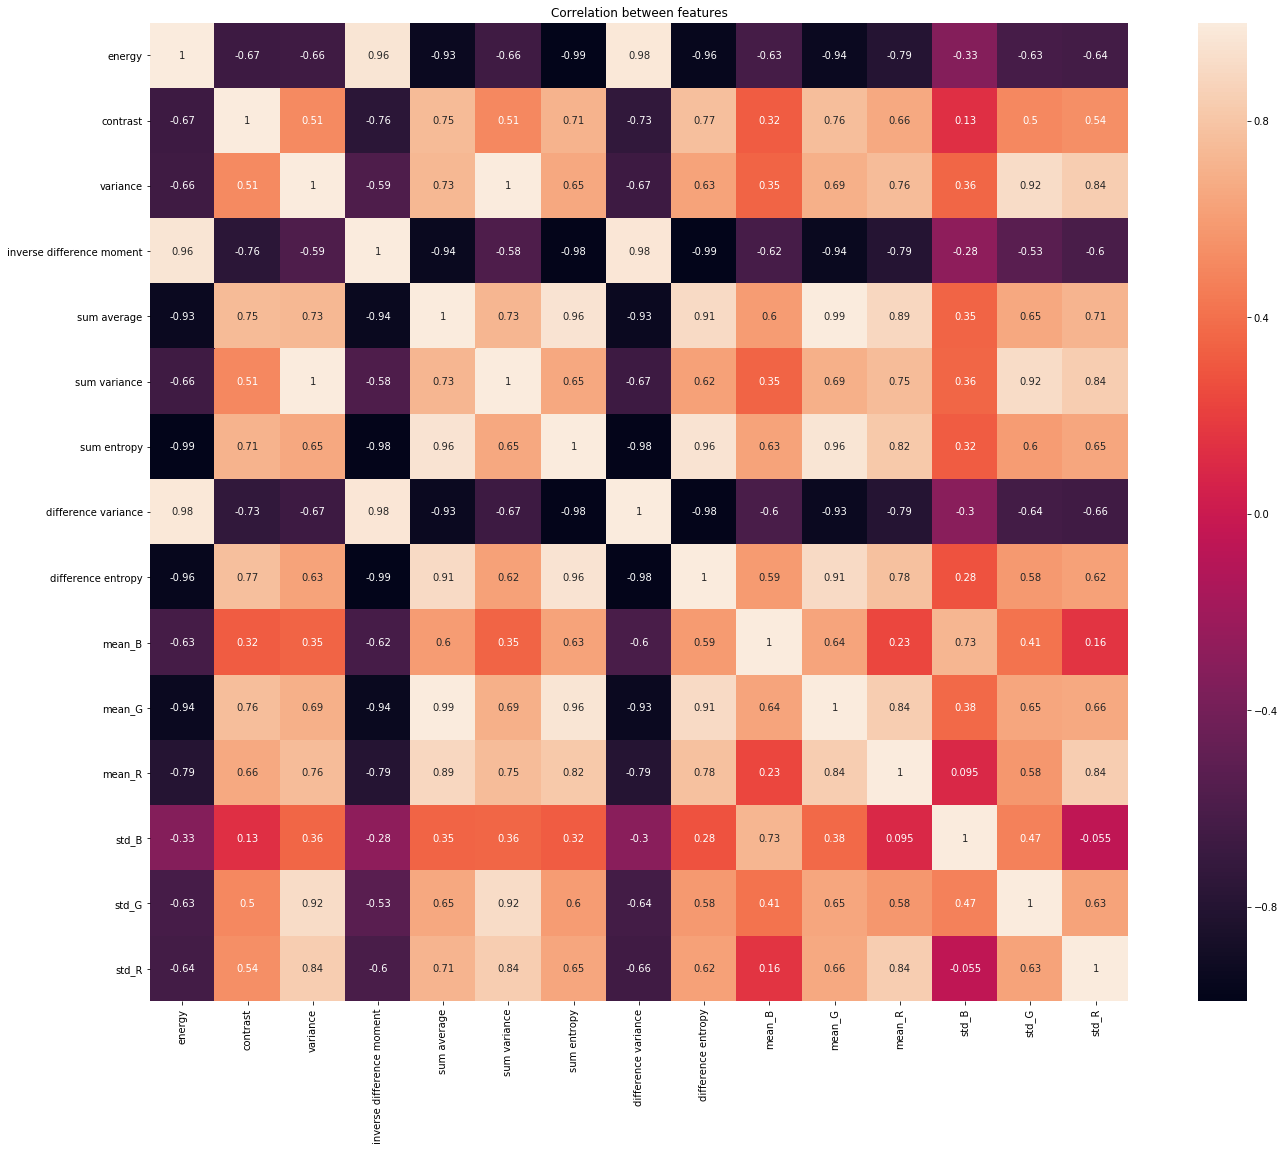

In [160]:
plt.figure(figsize=(25, 18))
corr = test_data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, square=True,annot=True,linecolor="black") #cmap='YlGnBu',
plt.title("Correlation between features")

In [161]:
test_data = test_data.drop('sum variance', 1)

In [162]:
print(min_element)
print()
print(max_element)
print()

[0.011069509097800984, 15.572683744138258, 723.7659687624123, 0.37053545795908094, 19.38180473937968, 2875.0273282599305, 1.1165259672405896, 1.384899361478592, 0.00047385081100294763, 0.6390858602226379, 0.906940460205078, 11.735050201416016, 4.3930206298828125, 5.822115522862383, 29.857774066962445, 13.865329940466271]

[0.824459635970216, 199.72798759999256, 8034.254522557166, 0.9430541073896348, 258.35351396449107, 32107.124024886074, 7.665840358364549, 10.380966022795953, 0.0035338738644745023, 3.8580077633114613, 130.77779006958008, 166.32170486450198, 87.93492889404297, 99.4731501591503, 117.60844643014582, 91.89011498742487]



### Next Step is the model Selection

#### Training 

#### Evaluation

#### Hyperparameter Tuning



####  Support Vector machine works well for multiclass classification.

In [163]:
from sklearn import svm
from sklearn.metrics import accuracy_score

#### SVC model 

In [164]:
model = svm.SVC()

## Training of dataset

In [165]:
model.fit(train_data,train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Testing of the trained model

In [166]:
predict_label = model.predict(test_data)

### Evaluation of the trained model 

In [167]:
accuracy = accuracy_score(test_label,predict_label)

In [168]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 91.67



## Hyper-Parameter Tuning

#### Regularization parameter C - high C value implies strict classification.

#### Gamma parameter - high gamma parameter value implies only nearby points (support vector) are considered for classification.

#### Kernel - Radial Basis Kernel(rbf) , linear kernel are popular choices.

In [169]:
model = svm.SVC(kernel = 'linear')

In [170]:
model.fit(train_data,train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [171]:
predict_label = model.predict(test_data)

In [172]:
accuracy = accuracy_score(test_label,predict_label)

In [173]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 92.86


### Case 2

In [174]:
model = svm.SVC(kernel = 'linear',C=10,gamma = 1)

In [175]:
model.fit(train_data,train_label)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [176]:
predict_label = model.predict(test_data)

In [177]:
accuracy = accuracy_score(test_label,predict_label)

In [178]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 94.64


### Case 3

In [179]:
model = svm.SVC(kernel = 'linear',C=10,gamma = 2)

In [180]:
model.fit(train_data,train_label)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [181]:
predict_label = model.predict(test_data)

In [182]:
accuracy = accuracy_score(test_label,predict_label)

In [183]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 94.64


### Case 4

In [184]:
model = svm.SVC(kernel = 'linear',C=10,gamma = 0.02)

In [185]:
model.fit(train_data,train_label)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.02, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [186]:
predict_label = model.predict(test_data)

In [187]:
accuracy = accuracy_score(test_label,predict_label)

In [188]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 94.64


#### Case 5

In [189]:
model = svm.SVC(kernel = 'linear',C=100)

In [190]:
model.fit(train_data,train_label)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [191]:
predict_label = model.predict(test_data)

In [192]:
accuracy = accuracy_score(test_label,predict_label)

In [193]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 92.86


### Case 6

In [194]:
model = svm.SVC(kernel = 'rbf',C=10,gamma=1)

In [195]:
model.fit(train_data,train_label)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [196]:
predict_label = model.predict(test_data)

In [197]:
accuracy = accuracy_score(test_label,predict_label)

In [198]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 94.94


### Case 7

In [199]:
model = svm.SVC(kernel = 'rbf',C=100,gamma=1)

In [200]:
model.fit(train_data,train_label)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [201]:
predict_label = model.predict(test_data)

In [202]:
accuracy = accuracy_score(test_label,predict_label)

In [203]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 94.05


## Case 8

In [204]:
model = svm.SVC(kernel = 'rbf',C=100,gamma=2)

In [205]:
model.fit(train_data,train_label)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [206]:
predict_label = model.predict(test_data)

In [207]:
accuracy = accuracy_score(test_label,predict_label)

In [208]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 92.86


## Case 9

In [209]:
model = svm.SVC(kernel = 'rbf',C=100,gamma=0.01)

In [210]:
model.fit(train_data,train_label)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [211]:
predict_label = model.predict(test_data)

In [212]:
accuracy = accuracy_score(test_label,predict_label)

In [213]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 92.56


### Case 10

In [214]:
model = svm.SVC(kernel = 'rbf',C=1,gamma=0.01)

In [215]:
model.fit(train_data,train_label)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [216]:
predict_label = model.predict(test_data)

In [217]:
accuracy = accuracy_score(test_label,predict_label)

In [218]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 88.10


### Case 11

In [219]:
model = svm.SVC(kernel = 'rbf', C=0.0001)

In [220]:
model.fit(train_data,train_label)

SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [221]:
predict_label = model.predict(test_data)

In [222]:
accuracy = accuracy_score(test_label,predict_label)

In [223]:
model.score(test_data,test_label)

0.8809523809523809

In [224]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 88.10


## Decision Tree Classifier

#### case 1

In [225]:
from sklearn import tree

In [226]:
model = tree.DecisionTreeClassifier()

In [227]:
model.fit(train_data,train_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [228]:
predict_label = model.predict(test_data)

In [229]:
accuracy = accuracy_score(test_label,predict_label)

In [230]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 87.80


#### case 2

In [231]:
model = tree.DecisionTreeClassifier(criterion = 'entropy')

In [232]:
model.fit(train_data,train_label)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [233]:
predict_label = model.predict(test_data)

In [234]:
accuracy = accuracy_score(test_label,predict_label)

In [235]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 80.65



#### case 3

In [236]:
model = tree.DecisionTreeClassifier(min_samples_split = 2)

In [237]:
model.fit(train_data,train_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [238]:
predict_label = model.predict(test_data)

In [239]:
accuracy = accuracy_score(test_label,predict_label)

In [240]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 87.50


#### case 4

In [241]:
model = tree.DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 79)

In [242]:
model.fit(train_data,train_label)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=79,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [243]:
predict_label = model.predict(test_data)

In [244]:
accuracy = accuracy_score(test_label,predict_label)

In [245]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 51.19


## K-NN Classifier

#### case 1

In [246]:
from sklearn.neighbors import KNeighborsClassifier

In [247]:
model = KNeighborsClassifier(n_neighbors = 3) 

In [248]:
model.fit(train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [249]:
predict_label = model.predict(test_data)

In [250]:
accuracy = accuracy_score(test_label,predict_label)

In [251]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 68.75


#### case 2

In [252]:
model = KNeighborsClassifier() 

In [253]:
model.fit(train_data,train_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [254]:
predict_label = model.predict(test_data)

In [255]:
accuracy = accuracy_score(test_label,predict_label)

In [256]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 64.88


#### case 3

In [257]:
model = KNeighborsClassifier(n_neighbors = 5,algorithm = 'kd_tree') 

In [258]:
model.fit(train_data,train_label)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [259]:
predict_label = model.predict(test_data)

In [260]:
accuracy = accuracy_score(test_label,predict_label)

In [261]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 64.88


#### case 4

In [262]:
model = KNeighborsClassifier(n_neighbors = 5,algorithm = 'ball_tree')

In [263]:
model.fit(train_data,train_label)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [264]:
predict_label = model.predict(test_data)

In [265]:
accuracy = accuracy_score(test_label,predict_label)

In [266]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 64.88


#### case 5

In [267]:
model = KNeighborsClassifier(n_neighbors = 6,algorithm = 'brute')

In [268]:
model.fit(train_data,train_label)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [269]:
predict_label = model.predict(test_data)

In [270]:
accuracy = accuracy_score(test_label,predict_label)

In [271]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 64.88


### Random Forest Classifier

#### case 1

In [272]:
from sklearn.ensemble import RandomForestClassifier

/home/ln-2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [273]:
model = RandomForestClassifier()

In [274]:
model.fit(train_data,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [275]:
predict_label = model.predict(test_data)

In [276]:
accuracy = accuracy_score(test_label,predict_label)

In [277]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 93.15


#### case 2

In [278]:
model = RandomForestClassifier(n_estimators = 5)

In [279]:
model.fit(train_data,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [280]:
predict_label = model.predict(test_data)

In [281]:
accuracy = accuracy_score(test_label,predict_label)

In [282]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 91.07


#### case 3

In [283]:
model = RandomForestClassifier(n_estimators = 70)

In [284]:
model.fit(train_data,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [285]:
predict_label = model.predict(test_data)

In [286]:
accuracy = accuracy_score(test_label,predict_label)

In [287]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 91.96


#### case 4

In [288]:
model = RandomForestClassifier(criterion = 'entropy')

In [289]:
model.fit(train_data,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [290]:
predict_label = model.predict(test_data)

In [291]:
accuracy = accuracy_score(test_label,predict_label)

In [292]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 90.18


#### case 5

In [293]:
model = RandomForestClassifier(n_estimators = 30, criterion = 'entropy')

In [294]:
model.fit(train_data,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [295]:
predict_label = model.predict(test_data)

In [296]:
accuracy = accuracy_score(test_label,predict_label)

In [297]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 93.15


#### case 6

In [298]:
model = RandomForestClassifier(n_estimators = 100,criterion = 'entropy')

In [299]:
model.fit(train_data,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [300]:
predict_label = model.predict(test_data)

In [301]:
accuracy = accuracy_score(test_label,predict_label)

In [302]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 94.05


### AdaBoost Classifier

#### case 1

In [303]:
from sklearn.ensemble import AdaBoostClassifier

In [304]:
dtree = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 1)
adabst = AdaBoostClassifier(base_estimator = dtree, n_estimators = 5000, learning_rate = 0.05, random_state = 42)

In [305]:
adabst.fit(train_data,train_label)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=5000, random_state=42)

In [306]:
predict_label = adabst.predict(test_data)

In [307]:
accuracy = accuracy_score(test_label,predict_label)

In [308]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 75.89


### case 2

In [309]:
dtree = tree.DecisionTreeClassifier(criterion = 'gini')
adabst = AdaBoostClassifier(base_estimator = dtree, n_estimators = 5000, learning_rate = 0.05, random_state = 42)

In [310]:
adabst.fit(train_data,train_label)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=5000, random_state=42)

In [311]:
predict_label = adabst.predict(test_data)

In [312]:
accuracy = accuracy_score(test_label,predict_label)

In [313]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 83.33


#### case 3

In [314]:
dtree = tree.DecisionTreeClassifier(min_samples_split = 10)
adabst = AdaBoostClassifier(base_estimator = dtree, n_estimators = 1000, learning_rate = 0.05, random_state = 42)

In [315]:
adabst.fit(train_data,train_label)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.05, n_estimators=1000, random_state=42)

In [316]:
predict_label = adabst.predict(test_data)

In [317]:
accuracy = accuracy_score(test_label,predict_label)

In [318]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 87.20


#### case 4

In [319]:
dtree = tree.DecisionTreeClassifier(min_samples_split = 10)
adabst = AdaBoostClassifier(base_estimator = dtree, n_estimators = 5000, learning_rate = 0.01, random_state = 42)

In [320]:
adabst.fit(train_data,train_label)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=5000, random_state=42)

In [321]:
predict_label = adabst.predict(test_data)

In [322]:
accuracy = accuracy_score(test_label,predict_label)

In [323]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 88.99


#### case 5

In [324]:
dtree = tree.DecisionTreeClassifier(min_samples_split = 10)
adabst = AdaBoostClassifier(base_estimator = dtree, n_estimators = 5000, learning_rate = 0.005, random_state = 42)

In [325]:
adabst.fit(train_data,train_label)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.005, n_estimators=5000, random_state=42)

In [326]:
predict_label = adabst.predict(test_data)

In [327]:
accuracy = accuracy_score(test_label,predict_label)

In [328]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 87.50


### Cross-validation for model selection



In [329]:
models = [] 
value = [] 

#### K-fold Cross-validation for SVM classifier

In [330]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [331]:
clf = svm.SVC()

In [332]:
kernal = ['linear','rbf']
C = [0.001,0.01,0.1,1,10,100,1000]
gamma = [0.002,0.02,0.2,1,10,100,1000]

In [333]:
gride = dict(kernel = kernal,C = C, gamma = gamma)

In [334]:
grid_clf = GridSearchCV(clf, param_grid = gride, cv=5, scoring='accuracy', return_train_score=False, n_jobs=-1)

In [335]:
grid_clf.fit(train_data, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ['linear', 'rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.002, 0.02, 0.2, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [336]:
pd.DataFrame(grid_clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.504762,0.009817,"{'C': 0.001, 'gamma': 0.002, 'kernel': 'linear'}"
1,0.504762,0.009817,"{'C': 0.001, 'gamma': 0.002, 'kernel': 'rbf'}"
2,0.504762,0.009817,"{'C': 0.001, 'gamma': 0.02, 'kernel': 'linear'}"
3,0.504762,0.009817,"{'C': 0.001, 'gamma': 0.02, 'kernel': 'rbf'}"
4,0.504762,0.009817,"{'C': 0.001, 'gamma': 0.2, 'kernel': 'linear'}"
5,0.504762,0.009817,"{'C': 0.001, 'gamma': 0.2, 'kernel': 'rbf'}"
6,0.504762,0.009817,"{'C': 0.001, 'gamma': 1, 'kernel': 'linear'}"
7,0.504762,0.009817,"{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}"
8,0.504762,0.009817,"{'C': 0.001, 'gamma': 10, 'kernel': 'linear'}"
9,0.504762,0.009817,"{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}"


In [337]:
print(grid_clf.cv_results_['params'][0])
print(grid_clf.cv_results_['mean_test_score'][0])

{'C': 0.001, 'gamma': 0.002, 'kernel': 'linear'}
0.5047619047619047


In [338]:
grid_mean_scores = grid_clf.cv_results_['mean_test_score']
print(grid_mean_scores)

[0.5047619  0.5047619  0.5047619  0.5047619  0.5047619  0.5047619
 0.5047619  0.5047619  0.5047619  0.5047619  0.5047619  0.5047619
 0.5047619  0.5047619  0.5047619  0.5047619  0.5047619  0.5047619
 0.5047619  0.5047619  0.5047619  0.5047619  0.5047619  0.5047619
 0.5047619  0.5047619  0.5047619  0.5047619  0.68095238 0.5047619
 0.68095238 0.5047619  0.68095238 0.5047619  0.68095238 0.73809524
 0.68095238 0.54761905 0.68095238 0.5047619  0.68095238 0.5047619
 0.82857143 0.5047619  0.82857143 0.5047619  0.82857143 0.82857143
 0.82857143 0.85714286 0.82857143 0.96190476 0.82857143 0.96190476
 0.82857143 0.9952381  0.92380952 0.5047619  0.92380952 0.82857143
 0.92380952 0.92380952 0.92380952 0.93809524 0.92380952 0.96190476
 0.92380952 0.9952381  0.92380952 0.9952381  0.93333333 0.82857143
 0.93333333 0.87619048 0.93333333 0.92857143 0.93333333 0.95714286
 0.93333333 0.9952381  0.93333333 0.9952381  0.93333333 0.9952381
 0.98571429 0.88095238 0.98571429 0.93809524 0.98571429 0.98095238
 0

In [339]:
print(grid_clf.best_score_)
print(grid_clf.best_params_)
print(grid_clf.best_estimator_)

0.9952380952380953
{'C': 1, 'gamma': 1000, 'kernel': 'rbf'}
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### K-fold Cross-validation for Decision Tree Classifier

In [340]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')

In [341]:
criterion = ['entropy','gini']
min_samples_split = [2,3,4,5,6]

In [342]:
gride = dict(criterion = criterion, min_samples_split = min_samples_split)

In [343]:
grid_clf = GridSearchCV(clf, param_grid = gride, cv=5, scoring='accuracy', return_train_score=False, n_jobs=-1)

In [344]:
grid_clf.fit(train_data, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['entropy', 'gini'], 'min_samples_split': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [345]:
pd.DataFrame(grid_clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.966667,0.042123,"{'criterion': 'entropy', 'min_samples_split': 2}"
1,0.957143,0.035642,"{'criterion': 'entropy', 'min_samples_split': 3}"
2,0.957143,0.035642,"{'criterion': 'entropy', 'min_samples_split': 4}"
3,0.957143,0.035642,"{'criterion': 'entropy', 'min_samples_split': 5}"
4,0.957143,0.035642,"{'criterion': 'entropy', 'min_samples_split': 6}"
5,0.952381,0.033318,"{'criterion': 'gini', 'min_samples_split': 2}"
6,0.966667,0.035344,"{'criterion': 'gini', 'min_samples_split': 3}"
7,0.976190,0.020942,"{'criterion': 'gini', 'min_samples_split': 4}"
8,0.985714,0.018499,"{'criterion': 'gini', 'min_samples_split': 5}"
9,0.966667,0.035344,"{'criterion': 'gini', 'min_samples_split': 6}"


In [346]:
print(grid_clf.cv_results_['params'][0])
print(grid_clf.cv_results_['mean_test_score'][0])

{'criterion': 'entropy', 'min_samples_split': 2}
0.9666666666666667


In [347]:
grid_mean_scores = grid_clf.cv_results_['mean_test_score']
print(grid_mean_scores)

[0.96666667 0.95714286 0.95714286 0.95714286 0.95714286 0.95238095
 0.96666667 0.97619048 0.98571429 0.96666667]


In [348]:
print(grid_clf.best_score_)
print(grid_clf.best_params_)
print(grid_clf.best_estimator_)

0.9857142857142858
{'criterion': 'gini', 'min_samples_split': 5}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


#### K-fold Cross-validation for Naive-Bayes Classifier

In [349]:
from sklearn.naive_bayes import GaussianNB

In [350]:
model = GaussianNB()

In [351]:
scores = cross_val_score(model,train_data,train_label,cv=5)

In [352]:
scores

array([0.79545455, 0.78571429, 0.71428571, 0.76190476, 0.825     ])

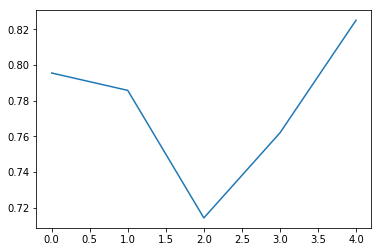

In [353]:
plt.plot(range(5),scores)

In [354]:
scores.mean()

0.7764718614718614

#### k-fold Cross-validation for k-nearest neighbour classifier

In [355]:
clf = KNeighborsClassifier() 

In [356]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

In [357]:
gride = dict(n_neighbors=k_range, weights=weight_options)

In [358]:
grid_clf = GridSearchCV(clf, param_grid = gride, cv=5, scoring='accuracy', return_train_score=False)

In [359]:
grid_clf.fit(train_data, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [360]:
pd.DataFrame(grid_clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.985714,0.011664,"{'n_neighbors': 1, 'weights': 'uniform'}"
1,0.985714,0.011664,"{'n_neighbors': 1, 'weights': 'distance'}"
2,0.952381,0.039776,"{'n_neighbors': 2, 'weights': 'uniform'}"
3,0.985714,0.011664,"{'n_neighbors': 2, 'weights': 'distance'}"
4,0.933333,0.057147,"{'n_neighbors': 3, 'weights': 'uniform'}"
5,0.971429,0.023450,"{'n_neighbors': 3, 'weights': 'distance'}"
6,0.923810,0.055398,"{'n_neighbors': 4, 'weights': 'uniform'}"
7,0.971429,0.023450,"{'n_neighbors': 4, 'weights': 'distance'}"
8,0.900000,0.040002,"{'n_neighbors': 5, 'weights': 'uniform'}"
9,0.952381,0.036893,"{'n_neighbors': 5, 'weights': 'distance'}"


In [361]:
print(grid_clf.cv_results_['params'][0])
print(grid_clf.cv_results_['mean_test_score'][0])

{'n_neighbors': 1, 'weights': 'uniform'}
0.9857142857142858


In [362]:
grid_mean_scores = grid_clf.cv_results_['mean_test_score']
print(grid_mean_scores)

[0.98571429 0.98571429 0.95238095 0.98571429 0.93333333 0.97142857
 0.92380952 0.97142857 0.9        0.95238095 0.89047619 0.95238095
 0.85714286 0.95238095 0.85238095 0.95238095 0.83333333 0.94761905
 0.83333333 0.95238095 0.7952381  0.95238095 0.7952381  0.94761905
 0.78571429 0.95714286 0.78095238 0.95238095 0.78095238 0.95714286
 0.77142857 0.94285714 0.77619048 0.95238095 0.77142857 0.95238095
 0.78571429 0.95714286 0.79047619 0.95714286 0.7952381  0.96666667
 0.7952381  0.97619048 0.76666667 0.97142857 0.76190476 0.97142857
 0.74285714 0.97142857 0.74285714 0.97142857 0.73809524 0.96666667
 0.72380952 0.97142857 0.71904762 0.97142857 0.71904762 0.96666667]


In [363]:
print(grid_clf.best_score_)
print(grid_clf.best_params_)
print(grid_clf.best_estimator_)

0.9857142857142858
{'n_neighbors': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')



#### K-fold Cross-validation for Random Forset Classifier 

In [364]:
clf = RandomForestClassifier()

In [365]:
n_estimators = [10,30,50,70,100]
criterion = ['gini','entropy']
min_samples_split = [2,3,4,5,6]

In [366]:
gride = dict(n_estimators = n_estimators, criterion = criterion, min_samples_split = min_samples_split)

In [367]:
grid_clf = GridSearchCV(clf, param_grid = gride, cv=5, scoring='accuracy', return_train_score=False, n_jobs=-1)

In [368]:
grid_clf.fit(train_data, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 30, 50, 70, 100], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [369]:
pd.DataFrame(grid_clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,1.000000,0.000000,"{'criterion': 'gini', 'min_samples_split': 2, ..."
1,0.995238,0.009249,"{'criterion': 'gini', 'min_samples_split': 2, ..."
2,1.000000,0.000000,"{'criterion': 'gini', 'min_samples_split': 2, ..."
3,1.000000,0.000000,"{'criterion': 'gini', 'min_samples_split': 2, ..."
4,0.995238,0.009524,"{'criterion': 'gini', 'min_samples_split': 2, ..."
5,0.980952,0.009249,"{'criterion': 'gini', 'min_samples_split': 3, ..."
6,0.995238,0.009524,"{'criterion': 'gini', 'min_samples_split': 3, ..."
7,1.000000,0.000000,"{'criterion': 'gini', 'min_samples_split': 3, ..."
8,0.985714,0.019196,"{'criterion': 'gini', 'min_samples_split': 3, ..."
9,0.995238,0.009817,"{'criterion': 'gini', 'min_samples_split': 3, ..."


In [370]:
print(grid_clf.cv_results_['params'][0])
print(grid_clf.cv_results_['mean_test_score'][0])

{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 10}
1.0


In [371]:
grid_mean_scores = grid_clf.cv_results_['mean_test_score']
print(grid_mean_scores)

[1.         0.9952381  1.         1.         0.9952381  0.98095238
 0.9952381  1.         0.98571429 0.9952381  0.98095238 0.99047619
 0.99047619 1.         0.9952381  0.99047619 0.98571429 0.98571429
 0.99047619 0.99047619 0.97619048 0.98571429 0.98571429 0.98571429
 0.98571429 0.98571429 0.98571429 0.98571429 0.98571429 0.99047619
 0.99047619 0.99047619 0.9952381  0.99047619 0.99047619 0.99047619
 0.99047619 0.98571429 0.99047619 0.98095238 0.99047619 0.98571429
 0.98571429 0.98571429 0.98571429 0.99047619 0.98571429 0.9952381
 0.98571429 0.98095238]


In [372]:
print(grid_clf.best_score_)
print(grid_clf.best_params_)
print(grid_clf.best_estimator_)

1.0
{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 10}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


#### K-fold Cross-validation for AdaBoost Classifier 

In [373]:
dtree = tree.DecisionTreeClassifier()
clf = AdaBoostClassifier(base_estimator = dtree)

In [374]:
n_estimators = [10,100,1000,2000,3000,4000,5000]
learning_rate = [0.01,0.02,0.03,0.04,0.05]
random_state = [1,14,24,28,35,42]

In [375]:
gride = dict(n_estimators = n_estimators, learning_rate = learning_rate, random_state = random_state)

In [376]:
grid_clf = GridSearchCV(clf, param_grid = gride, cv=5, scoring='accuracy', return_train_score=False, n_jobs=-1)

In [377]:
grid_clf.fit(train_data, train_label)

GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 100, 1000, 2000, 3000, 4000, 5000], 'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'random_state': [1, 14, 24, 28, 35, 42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [378]:
pd.DataFrame(grid_clf.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.966667,0.040951,"{'learning_rate': 0.01, 'n_estimators': 10, 'r..."
1,0.966667,0.035344,"{'learning_rate': 0.01, 'n_estimators': 10, 'r..."
2,0.961905,0.038082,"{'learning_rate': 0.01, 'n_estimators': 10, 'r..."
3,0.961905,0.027850,"{'learning_rate': 0.01, 'n_estimators': 10, 'r..."
4,0.966667,0.031571,"{'learning_rate': 0.01, 'n_estimators': 10, 'r..."
5,0.961905,0.045765,"{'learning_rate': 0.01, 'n_estimators': 10, 'r..."
6,0.966667,0.040951,"{'learning_rate': 0.01, 'n_estimators': 100, '..."
7,0.966667,0.035344,"{'learning_rate': 0.01, 'n_estimators': 100, '..."
8,0.961905,0.038082,"{'learning_rate': 0.01, 'n_estimators': 100, '..."
9,0.961905,0.027850,"{'learning_rate': 0.01, 'n_estimators': 100, '..."


In [379]:
print(grid_clf.cv_results_['params'][0])
print(grid_clf.cv_results_['mean_test_score'][0])

{'learning_rate': 0.01, 'n_estimators': 10, 'random_state': 1}
0.9666666666666667


In [380]:
grid_mean_scores = grid_clf.cv_results_['mean_test_score']
print(grid_mean_scores)

[0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.96190476
 0.96666667 0.96666667 0.96190476 0.96190476 0.96666667 0.9619

In [381]:
print(grid_clf.best_score_)
print(grid_clf.best_params_)
print(grid_clf.best_estimator_)

0.9666666666666667
{'learning_rate': 0.01, 'n_estimators': 10, 'random_state': 1}
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=10, random_state=1)


### Training And Testing

### Top 4 models are chosen by 5-fold cross-validation and that models are Support Vector Machine, Decision Tree, Random Forerst Classifier and Adaboost Classifier.

#### Support Vector Machine

In [382]:
model_svc = svm.SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [383]:
model_svc.fit(train_data,train_label)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Decision Tree

In [384]:
model_dtree = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [385]:
model_dtree.fit(train_data,train_label)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### Random Forest Classifier

In [386]:
model_random = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [387]:
model_random.fit(train_data,train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### AdaBoost Classifier

In [388]:
dtree = tree.DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

model_ada = AdaBoostClassifier(algorithm='SAMME.R',base_estimator= dtree, learning_rate=0.01, n_estimators=10, random_state=1)

In [389]:
model_ada.fit(train_data,train_label)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.01, n_estimators=10, random_state=1)

#### Prediction using SVM , Decision Tree, Random Forest Classifier and AdaBoost Classifier

In [390]:
pred_svc = model_svc.predict(test_data)

In [391]:
pred_dtree = model_dtree.predict(test_data)

In [392]:
pred_random = model_random.predict(test_data)

In [393]:
pred_ada = model_ada.predict(test_data)

In [394]:
print(len(pred_svc),len(test_label))

336 336


### Prediction using SVM classifier

In [395]:
from sklearn.metrics import confusion_matrix

In [396]:
result_svc = confusion_matrix(test_label,pred_svc)

In [397]:
result_svc

array([[289,   0,   7,   0],
       [ 12,   8,   0,   1],
       [  4,   0,   1,   0],
       [  1,   0,   0,  13]])

In [398]:
accuracy_svc = accuracy_score(test_label,pred_svc)

In [399]:
print(accuracy_svc)

0.9255952380952381


In [400]:
from sklearn.metrics import classification_report

In [401]:
report_svc = classification_report(test_label,pred_svc)

In [402]:
print(report_svc)

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       296
          1       1.00      0.38      0.55        21
          2       0.12      0.20      0.15         5
          3       0.93      0.93      0.93        14

avg / total       0.94      0.93      0.92       336



### Prediction using decision tree classifier

In [403]:
result_dtree = confusion_matrix(test_label,pred_dtree)

In [404]:
print("  Confusion Matrix\n",result_dtree)

  Confusion Matrix
 [[268   0  10  18]
 [  8   6   0   7]
 [  0   0   5   0]
 [  0   0   0  14]]


In [405]:
accuracy_dtree = accuracy_score(test_label,pred_dtree)

In [406]:
print(accuracy_dtree)

0.8720238095238095


In [407]:
report_dtree = classification_report(test_label,pred_dtree)

In [408]:
print(report_dtree)

             precision    recall  f1-score   support

          0       0.97      0.91      0.94       296
          1       1.00      0.29      0.44        21
          2       0.33      1.00      0.50         5
          3       0.36      1.00      0.53        14

avg / total       0.94      0.87      0.88       336



### Prediction using Random Forest Classifier

In [409]:
result_random = confusion_matrix(test_label,pred_random)

In [410]:
print("  Confusion Matrix\n",result_random)

  Confusion Matrix
 [[289   0   5   2]
 [ 18   2   0   1]
 [  0   0   1   4]
 [  0   0   0  14]]


In [411]:
accuracy_random = accuracy_score(test_label,pred_random)

In [412]:
print(accuracy_random)

0.9107142857142857


In [413]:
report_random = classification_report(test_label,pred_random)

In [414]:
print(report_random)

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       296
          1       1.00      0.10      0.17        21
          2       0.17      0.20      0.18         5
          3       0.67      1.00      0.80        14

avg / total       0.92      0.91      0.89       336



### Prediction using Ada-boost classifier

In [415]:
result_ada = confusion_matrix(test_label,pred_ada)

In [416]:
print("  Confusion Matrix\n",result_ada)

  Confusion Matrix
 [[267   1  10  18]
 [  8   6   0   7]
 [  0   0   1   4]
 [  0   0   0  14]]


In [417]:
accuracy_ada = accuracy_score(test_label,pred_ada)

In [418]:
print(accuracy_ada)

0.8571428571428571


In [419]:
report_ada = classification_report(test_label,pred_ada)

In [420]:
print(report_ada)

             precision    recall  f1-score   support

          0       0.97      0.90      0.94       296
          1       0.86      0.29      0.43        21
          2       0.09      0.20      0.13         5
          3       0.33      1.00      0.49        14

avg / total       0.92      0.86      0.87       336



### Final Ensemble prediction using Maximum Voting

In [421]:
final_pred = np.array([])

In [422]:
len(test_data)

336

In [423]:
for i in range(0,len(test_data)):
    final_pred = np.append(final_pred,stats.mode([pred_svc[i],pred_dtree[i],pred_random[i],pred_ada[i]]))

### Confusion Matrix

In [424]:
len(final_pred)

672

In [425]:
print(final_pred)

[1. 3. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 3. 4. 3. 4. 0. 4. 0. 4. 0. 2.
 0. 4. 0. 4. 0. 4. 0. 4. 0. 2. 3. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4.
 0. 4. 0. 4. 0. 4. 0. 4. 3. 2. 0. 4. 2. 3. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4.
 0. 4. 0. 2. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4.
 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 3. 4. 0. 4. 0. 4. 0. 4. 0. 2. 0. 4. 0. 2.
 0. 4. 0. 4. 0. 4. 3. 2. 0. 4. 0. 4. 1. 3. 0. 4. 0. 4. 0. 3. 0. 4. 0. 4.
 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 3. 4. 0. 4. 0. 4. 0. 4. 0. 4. 1. 3. 0. 4.
 3. 2. 0. 4. 0. 4. 0. 4. 0. 4. 0. 2. 0. 4. 0. 2. 1. 3. 0. 4. 0. 2. 0. 2.
 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4.
 0. 4. 0. 4. 0. 4. 0. 4. 2. 3. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4.
 0. 3. 0. 2. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 3. 4. 0. 4. 0. 4. 0. 4. 0. 4.
 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 2. 0. 4. 0. 4.
 0. 4. 0. 4. 0. 4. 0. 3. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4.
 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0. 4. 0.

In [426]:
prediction = final_pred.tolist()
prediction

[1.0,
 3.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 3.0,
 4.0,
 3.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 2.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 2.0,
 3.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 3.0,
 2.0,
 0.0,
 4.0,
 2.0,
 3.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 2.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 3.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 2.0,
 0.0,
 4.0,
 0.0,
 2.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 3.0,
 2.0,
 0.0,
 4.0,
 0.0,
 4.0,
 1.0,
 3.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 3.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 3.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 0.0,
 4.0,
 1.0,
 3.0,
 0.0

In [427]:
type(prediction[0])

float

In [428]:
final = prediction[0:len(prediction)-1:2]

In [429]:
final

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [430]:
for index, item in enumerate(final):
    final[index] = float(item)

In [431]:
len(test_label),len(final)

(336, 336)

In [432]:
result = confusion_matrix(test_label,final)

In [433]:
result

array([[289,   0,   7,   0],
       [ 12,   8,   0,   1],
       [  0,   0,   1,   4],
       [  0,   0,   0,  14]])

In [434]:
accuracy = accuracy_score(test_label,final)

In [435]:
accuracy

0.9285714285714286

In [436]:
print('Accuracy of the model is {:.2f}'.format(accuracy*100))

Accuracy of the model is 92.86


In [437]:
from sklearn.metrics import classification_report

In [438]:
report = classification_report(test_label,final)

In [439]:
print(report)

             precision    recall  f1-score   support

          0       0.96      0.98      0.97       296
          1       1.00      0.38      0.55        21
          2       0.12      0.20      0.15         5
          3       0.74      1.00      0.85        14

avg / total       0.94      0.93      0.93       336



###  Comparison of different Classifier and Final ensemble

In [440]:
accuracy_list = []
accuracy_list.extend([accuracy_svc*100,accuracy_dtree*100,accuracy_random*100,accuracy_ada*100,accuracy*100])

In [441]:
print(accuracy_list)

[92.55952380952381, 87.20238095238095, 91.07142857142857, 85.71428571428571, 92.85714285714286]


In [442]:
label = ['SVM','Decision Tree','Ramdom Forest','Ada-boost','Proposed Model']

In [443]:
index = np.arange(len(label))

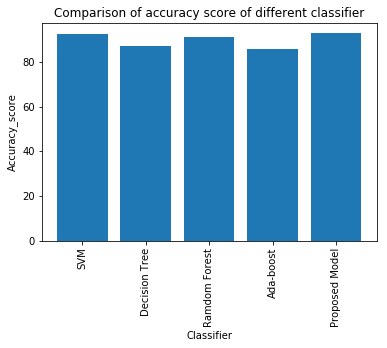

In [444]:
plt.bar(index,accuracy_list)
plt.xlabel('Classifier', fontsize=10)
plt.ylabel('Accuracy_score', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=90)
plt.title('Comparison of accuracy score of different classifier')
plt.show()

In [445]:
def recommendation_by_prediction(pic, model_svc,model_dtree,model_random,model_ada):
    
    ### Image Processing
    print(pic)
    pic = cv.imread(pic)
    dim = (512,512)
    r_img = cv.resize(pic,dim)
    
    ### Extract image features
    feature_list = extract_feature(pic).tolist()
    siz = len(feature_list)
    
    l1 = list(min_element)
    l2 = list(max_element)
    
    
    
    l1.pop(5)
    l2.pop(6)
    
    l1.pop(5)
    l2.pop(6)
    
    # Scaling of relevent feature and removal of irrelevent features
    j=0
    for i in range(siz):
        if(i == 2 or i == 6 or i == 8 or i == 11 or i == 12 or i == 19 or i == 20):
            pass
        else:
            feature_list[i] = (feature_list[i] - l1[j]) /(l2[j] - l1[j])    
            j = j + 1
    
    feature_list.pop(2)
    feature_list.pop(5)
    feature_list.pop(6)
    feature_list.pop(8)
    feature_list.pop(8)
    feature_list.pop(14)
    feature_list.pop(14)
    
    feature_list = [feature_list]
        
    ### Individual prediction result from each model
    pred_1 =  model_svc.predict(feature_list)
    pred_2 =  model_dtree.predict(feature_list)
    pred_3 =  model_random.predict(feature_list)
    pred_4 =  model_ada.predict(feature_list)
    
    
    ### Final class of the leaf
    final = np.array([])
    final = np.append(final,stats.mode([pred_1,pred_2,pred_3,pred_4]))
    final = final.tolist()
    #print(len(final))
    disease_label = {0:'Healthy Leaf',1:'Algal Leaf Spot',2:'Blister Blight',3:'Grey Spot'}
    #final = final[0:len(prediction)-1:2]
    
    return(disease_label[int(final[0])])


In [450]:
import tkinter as tk
from tkinter import filedialog
root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename()

#### Above function gives a dialog box to search computer for an appropriate image

### Dialog Box



In [457]:
%%html
<img src = "test.png",width = 200,height=200>

In [458]:
%%html
<img src = "test2.png",width = 200,height=200>

In [449]:
typo = recommendation_by_prediction(file_path,model_svc,model_dtree,model_random,model_ada)

print("Disease for that leaf: ",typo)

/home/ln-2/Desktop/Project/disease-final/recommendation/check4.jpg
Disease for that leaf:  Blister Blight
